In [53]:
import pennylane as qml
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import pandas as pd

In [54]:
def abs_error(m1, m2):
    return abs(m1 - m2)


def relative_error(m1, m2):
    return abs_error(m1, m2) / abs(m1)


def mse(m1,m2, variance) -> float:
    return math.sqrt(abs(m1 - m2)**2 + variance)


def print_data(name, mean, true_mean, samples__, variance):
    return {
        "Name": name,
        "Mean": mean,
        "Absolute Error": abs_error(true_mean, mean),
        "Relative Error": relative_error(true_mean, mean),
        "MSE": mse(true_mean, mean, variance),
        "Variance": variance,
        "Samples": samples__,
    }

In [55]:
m = 5
M = 2**m

xmax = np.pi 
xs = np.linspace(-xmax, xmax, M)

probs = np.array([norm().pdf(x) for x in xs])
probs /= np.sum(probs)

In [56]:
samples = []
for i in range(1,7):
    samples_qmc = 2**i
    error = 1/samples_qmc
    samples_mc = round(1/error**2)
    
    samples.append({"Error" : error, "Classical Samples": samples_mc, "Quantum Samples": samples_qmc})
    
    
df_samples = pd.DataFrame(samples)
quantum_samples = [int(math.log2(n)) for n in df_samples["Quantum Samples"].to_list()]
classical_samples = df_samples["Classical Samples"].to_list()

print(df_samples)
print(df_samples.to_latex(index=False, float_format="%.4f"))

      Error  Classical Samples  Quantum Samples
0  0.500000                  4                2
1  0.250000                 16                4
2  0.125000                 64                8
3  0.062500                256               16
4  0.031250               1024               32
5  0.015625               4096               64
\begin{tabular}{rrr}
\toprule
Error & Classical Samples & Quantum Samples \\
\midrule
0.5000 & 4 & 2 \\
0.2500 & 16 & 4 \\
0.1250 & 64 & 8 \\
0.0625 & 256 & 16 \\
0.0312 & 1024 & 32 \\
0.0156 & 4096 & 64 \\
\bottomrule
\end{tabular}



In [57]:
def func_f(x):
    return np.sin(x) ** 2

true_mean = math.sinh(1) / math.exp(1)

def mc_mean(numSamples):
    sampleData = []
    for _ in range(numSamples):
        sampleData.append(np.random.choice(xs, p=probs))
    values: list = func_f(sampleData)
    MCMean: float = np.mean(values)
    return MCMean, numSamples

In [58]:
mse_values = []
abs_values = []
num_samples_cmc = []
data_cmc = []
variances = []
abs_values = []

for samples_ in classical_samples:
    num_samples_cmc.append(samples_)
    answer, num = mc_mean(samples_)

    results = []
    for _ in range(5):
        result, numSamples = mc_mean(samples_)
        results.append(result)
        
    variance = np.var(results)

    answer = print_data("MC Mean", mean = answer, true_mean=true_mean, samples__= numSamples, variance=variance)

    data_cmc.append(answer)
    mse_values.append(answer.get("MSE"))

    

In [59]:
df_cmc = pd.DataFrame(data_cmc)
print(df_cmc)
df_cmc = df_cmc.drop("Name", axis=1)
print(df_cmc.to_latex(index=False,))

      Name      Mean  Absolute Error  Relative Error       MSE  Variance  \
0  MC Mean  0.727006        0.294673        0.681590  0.382489  0.059466   
1  MC Mean  0.345360        0.086972        0.201170  0.096745  0.001795   
2  MC Mean  0.468329        0.035997        0.083262  0.062365  0.002594   
3  MC Mean  0.422044        0.010289        0.023798  0.017296  0.000193   
4  MC Mean  0.434566        0.002233        0.005166  0.008402  0.000066   
5  MC Mean  0.434751        0.002419        0.005595  0.003229  0.000005   

   Samples  
0        4  
1       16  
2       64  
3      256  
4     1024  
5     4096  
\begin{tabular}{rrrrrr}
\toprule
Mean & Absolute Error & Relative Error & MSE & Variance & Samples \\
\midrule
0.727006 & 0.294673 & 0.681590 & 0.382489 & 0.059466 & 4 \\
0.345360 & 0.086972 & 0.201170 & 0.096745 & 0.001795 & 16 \\
0.468329 & 0.035997 & 0.083262 & 0.062365 & 0.002594 & 64 \\
0.422044 & 0.010289 & 0.023798 & 0.017296 & 0.000193 & 256 \\
0.434566 & 0.002233 &

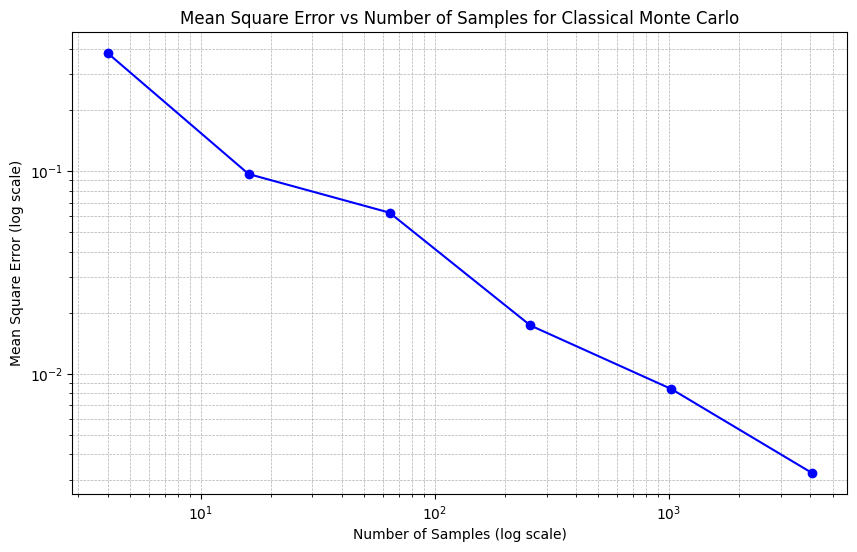

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(num_samples_cmc, mse_values, marker="o", linestyle="-", color="b")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Samples (log scale)")
plt.ylabel("Mean Square Error (log scale)")
plt.title("Mean Square Error vs Number of Samples for Classical Monte Carlo")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

In [61]:
# TODO Quantum Amplitude Estimation

In [62]:
def func(i):
    return np.sin(xs[i]) ** 2


mse_values_qc = []
num_samples = []
data = []
for n in quantum_samples:
    num_samples.append(2**n)
    N = 2**n

    target_wires = range(m + 1)
    estimation_wires = range(m + 1, n + m + 1)

    dev = qml.device("default.qubit", wires=(n + m + 1))

    @qml.qnode(dev)
    def circuit():
        qml.templates.QuantumMonteCarlo(
            probs,
            func,
            target_wires=target_wires,
            estimation_wires=estimation_wires,
        )
        return qml.probs(estimation_wires)

    results = []
    for _ in range(4, 17):
        qmc_probs = circuit()
        phase_estimated = np.argmax(circuit()[: int(N / 2)]) / N
        answer = (1 - np.cos(np.pi * phase_estimated)) / 2
        results.append(answer)
    variance = np.var(results)
    answer = np.mean(results)

    format_data = print_data("QMC", answer, true_mean, 2**n, variance=variance)

    mse_values_qc.append(format_data.get("MSE"))
    data.append(format_data)
    
    


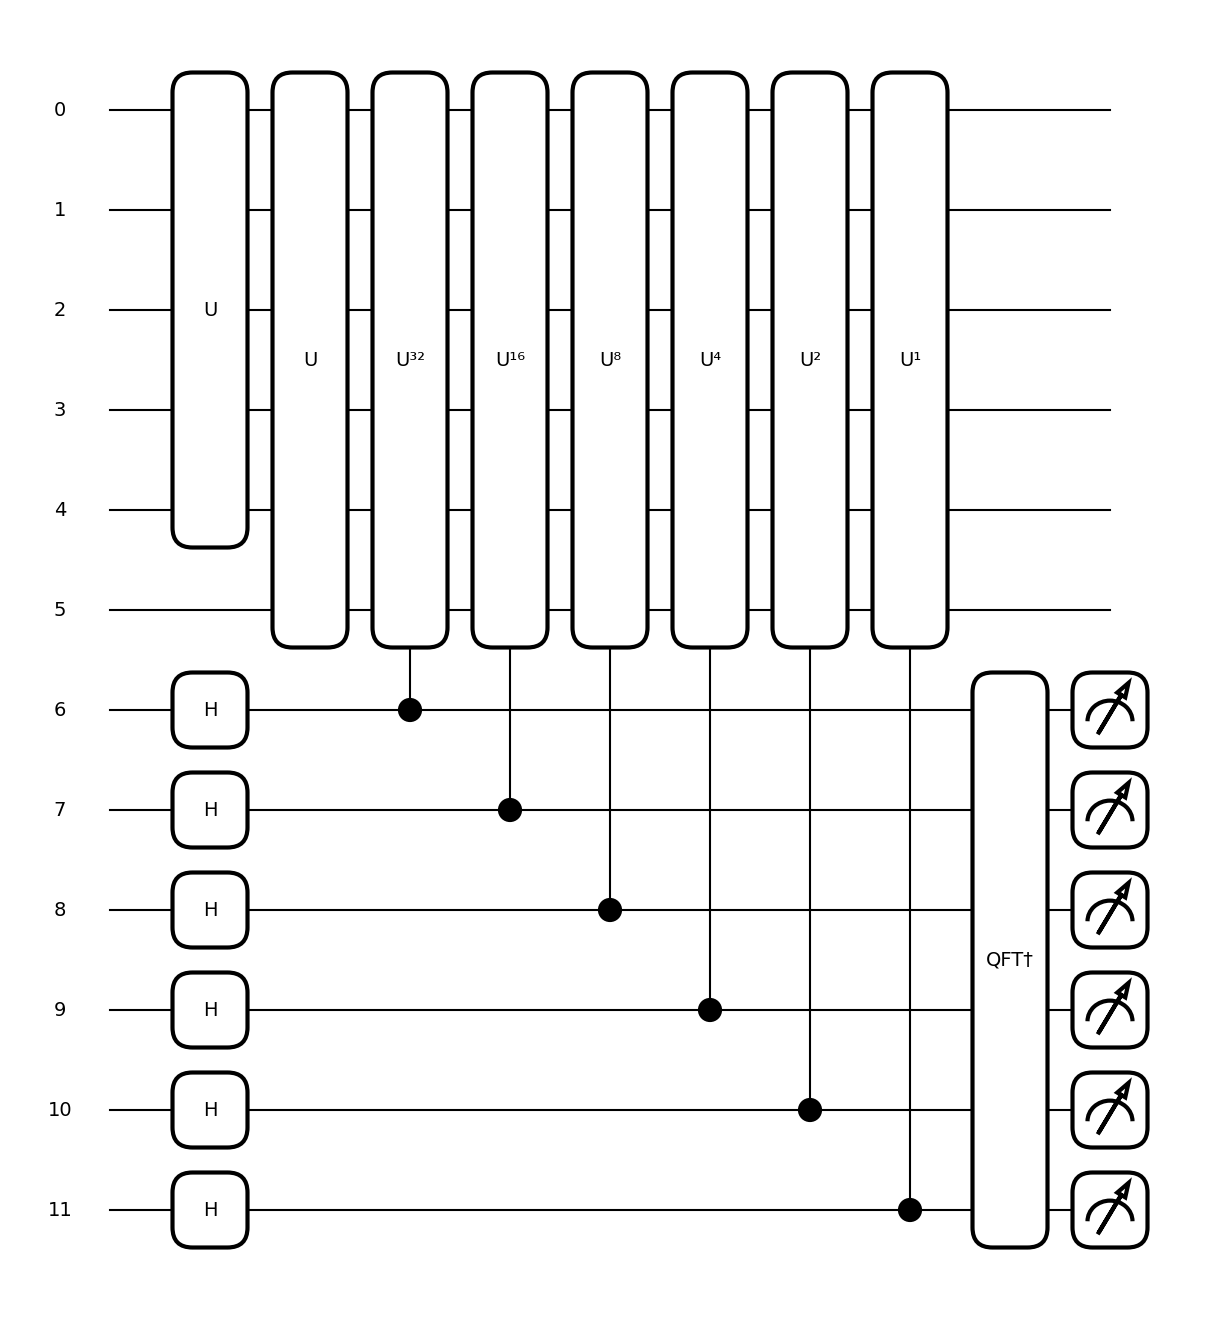

In [ ]:
fig, ax = qml.draw_mpl(circuit, level="device", style="black_white")()
fig.savefig(
    f"../circuits/pl_qmc.png", dpi=330, bbox_inches="tight"
)

In [64]:
df = pd.DataFrame(data)
print(df)
df = df.drop("Name", axis=1)
print(df.to_latex(index=False, ))

  Name      Mean  Absolute Error  Relative Error       MSE      Variance  \
0  QMC  0.000000        0.432332        1.000000  0.432332  0.000000e+00   
1  QMC  0.146447        0.285886        0.661264  0.285886  7.703720e-34   
2  QMC  0.308658        0.123674        0.286062  0.123674  3.081488e-33   
3  QMC  0.402455        0.029878        0.069108  0.029878  3.081488e-33   
4  QMC  0.450991        0.018659        0.043159  0.018659  1.232595e-32   
5  QMC  0.426635        0.005698        0.013179  0.005698  3.081488e-33   

   Samples  
0        2  
1        4  
2        8  
3       16  
4       32  
5       64  
\begin{tabular}{rrrrrr}
\toprule
Mean & Absolute Error & Relative Error & MSE & Variance & Samples \\
\midrule
0.000000 & 0.432332 & 1.000000 & 0.432332 & 0.000000 & 2 \\
0.146447 & 0.285886 & 0.661264 & 0.285886 & 0.000000 & 4 \\
0.308658 & 0.123674 & 0.286062 & 0.123674 & 0.000000 & 8 \\
0.402455 & 0.029878 & 0.069108 & 0.029878 & 0.000000 & 16 \\
0.450991 & 0.018659 & 0.

Text(0.5, 1.0, 'Mean Square Error vs Number of Samples for Quantum Monte Carlo')

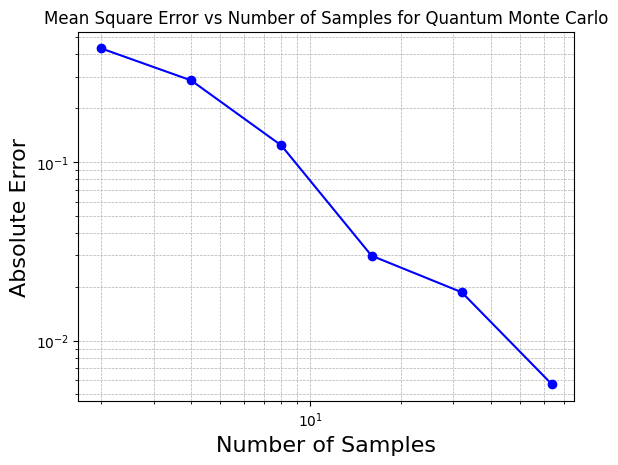

In [65]:
abs_error_list = df["Absolute Error"].to_list()
samples_numbers = df["Samples"].to_list()


plt.plot(samples_numbers, mse_values_qc,marker="o", linestyle="-", color="b")
plt.xlabel("Number of Samples", fontsize=16)
plt.ylabel("Absolute Error", fontsize=16)
plt.xscale("log", base=10)
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title("Mean Square Error vs Number of Samples for Quantum Monte Carlo")

Text(0.5, 1.0, 'Mean Square Error vs Number of Samples of CMC and QMC')

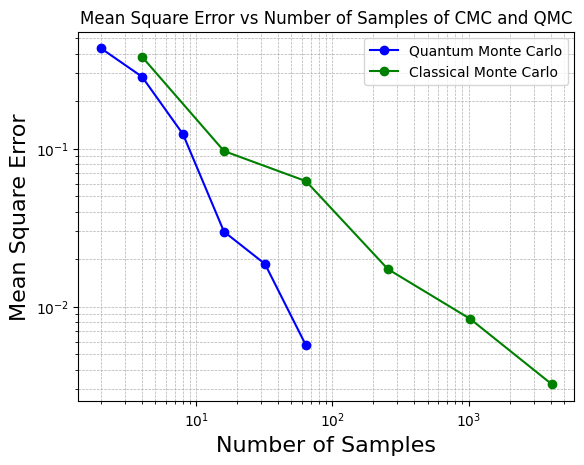

In [66]:
samples_numbers = df["Samples"].to_list()

plt.plot(samples_numbers, mse_values_qc,marker="o", linestyle="-", color="b", label="Quantum Monte Carlo")
plt.plot(num_samples_cmc, mse_values, marker="o", linestyle="-", color="g", label="Classical Monte Carlo")
plt.legend()
plt.xlabel("Number of Samples", fontsize=16)
plt.ylabel("Mean Square Error", fontsize=16)
plt.xscale("log", base=10)
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title("Mean Square Error vs Number of Samples of CMC and QMC")